In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [6]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


## Check by plotting a Spectogram

Pop


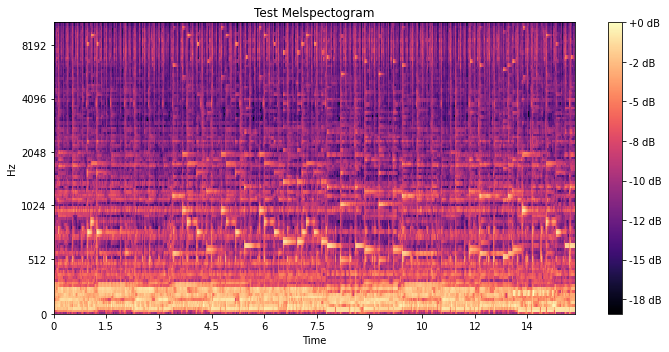

In [8]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [9]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [10]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [11]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
       
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_3/model_root/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_3/model_root/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [12]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [13]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Electronic'], ['Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 31s 169ms/step - loss: 0.4840 - accuracy: 0.8740 - val_loss: 0.3599 - val_accuracy: 0.8778

Epoch 00001: val_accuracy improved from -inf to 0.87778, saving model to ./models/model_root_n/folder1\model.h5
Epoch 2/30
99/99 [==============================] - 16s 160ms/step - loss: 0.3838 - accuracy: 0.8731 - val_loss: 0.3514 - val_accuracy: 0.8822

Epoch 00002: val_accuracy improved from 0.87778 to 0.88222, saving model to ./models/model_root_n/folder1\model.h5
Epoch 3/30
99/99 [==============================] - 14s 146ms/step - loss: 0.3700 - accuracy: 0.8727 - val_loss: 0.3342 - val_accuracy: 0.8811

Epoch 00003: val_accuracy did not improve from 0.88222
Epoch 4/30
99/99 [==============================] - 15s 147ms/step - loss: 0.3526 - accuracy: 0.8745 - val_loss: 0.3321 - val_acc

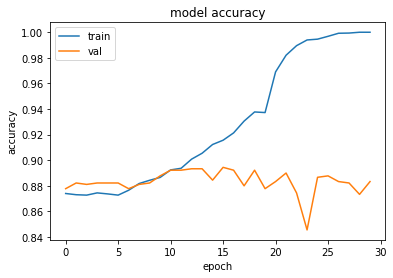

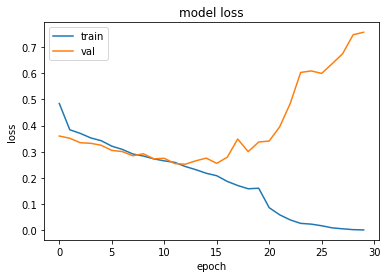

Folder num 2
Genre split [['Experimental'], ['Electronic', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 17s 158ms/step - loss: 0.5771 - accuracy: 0.8603 - val_loss: 0.3786 - val_accuracy: 0.8667

Epoch 00001: val_accuracy improved from -inf to 0.86667, saving model to ./models/model_root_n/folder2\model.h5
Epoch 2/30
99/99 [==============================] - 15s 148ms/step - loss: 0.3609 - accuracy: 0.8762 - val_loss: 0.3698 - val_accuracy: 0.8667

Epoch 00002: val_accuracy did not improve from 0.86667
Epoch 3/30
99/99 [==============================] - 16s 161ms/step - loss: 0.3387 - accuracy: 0.8794 - val_loss: 0.3676 - val_accuracy: 0.8656

Epoch 00003: val_accuracy did not improve from 0.86667
Epoch 4/30
99/99 [==============================] - 15s 147ms/step - loss: 0.3392 - accuracy: 0.8788 - val_loss: 0.3447 - val_accuracy: 0.8656

Epoch 00004: val_accuracy did not improve fro

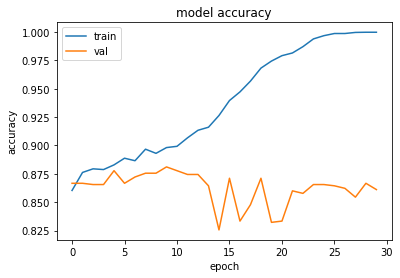

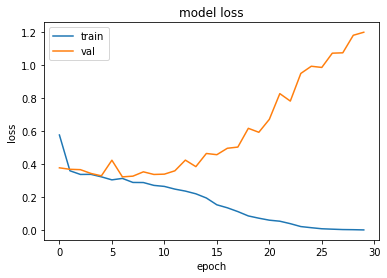

Folder num 3
Genre split [['Folk'], ['Electronic', 'Experimental', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 18s 165ms/step - loss: 0.8468 - accuracy: 0.8659 - val_loss: 0.3876 - val_accuracy: 0.8888

Epoch 00001: val_accuracy improved from -inf to 0.88877, saving model to ./models/model_root_n/folder3\model.h5
Epoch 2/30
99/99 [==============================] - 14s 146ms/step - loss: 0.3899 - accuracy: 0.8731 - val_loss: 0.3199 - val_accuracy: 0.8888

Epoch 00002: val_accuracy did not improve from 0.88877
Epoch 3/30
99/99 [==============================] - 14s 146ms/step - loss: 0.3278 - accuracy: 0.8675 - val_loss: 0.3194 - val_accuracy: 0.8854

Epoch 00003: val_accuracy did not improve from 0.88877
Epoch 4/30
99/99 [==============================] - 15s 147ms/step - loss: 0.2970 - accuracy: 0.8745 - val_loss: 0.2595 - val_accuracy: 0.8977

Epoch 00004: val_accuracy improved from 0.888

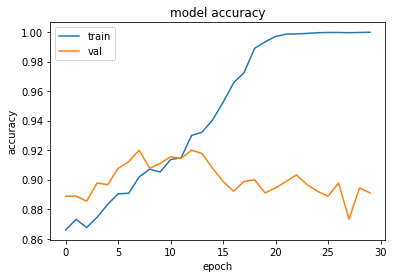

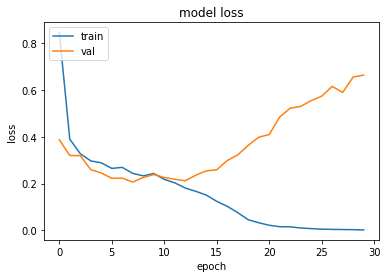

Folder num 4
Genre split [['Hip-Hop'], ['Electronic', 'Experimental', 'Folk', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 17s 152ms/step - loss: 0.6565 - accuracy: 0.8632 - val_loss: 0.3613 - val_accuracy: 0.8654

Epoch 00001: val_accuracy improved from -inf to 0.86541, saving model to ./models/model_root_n/folder4\model.h5
Epoch 2/30
99/99 [==============================] - 15s 149ms/step - loss: 0.3259 - accuracy: 0.8761 - val_loss: 0.3191 - val_accuracy: 0.8654

Epoch 00002: val_accuracy did not improve from 0.86541
Epoch 3/30
99/99 [==============================] - 15s 154ms/step - loss: 0.3253 - accuracy: 0.8769 - val_loss: 0.3549 - val_accuracy: 0.8654

Epoch 00003: val_accuracy did not improve from 0.86541
Epoch 4/30
99/99 [==============================] - 15s 147ms/step - loss: 0.3169 - accuracy: 0.8763 - val_loss: 0.3130 - val_accuracy: 0.8632

Epoch 00004: val_accuracy did not improve fro

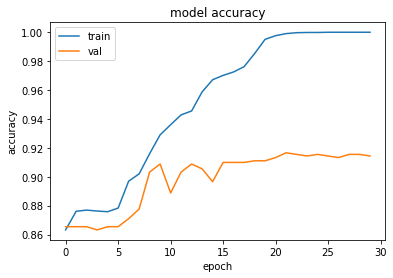

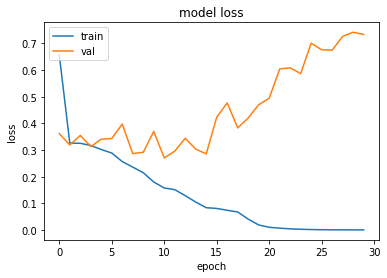

Folder num 5
Genre split [['Instrumental'], ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 16s 157ms/step - loss: 0.4850 - accuracy: 0.8634 - val_loss: 0.4017 - val_accuracy: 0.8643

Epoch 00001: val_accuracy improved from -inf to 0.86429, saving model to ./models/model_root_n/folder5\model.h5
Epoch 2/30
99/99 [==============================] - 15s 149ms/step - loss: 0.3331 - accuracy: 0.8759 - val_loss: 0.3547 - val_accuracy: 0.8654

Epoch 00002: val_accuracy improved from 0.86429 to 0.86541, saving model to ./models/model_root_n/folder5\model.h5
Epoch 3/30
99/99 [==============================] - 15s 148ms/step - loss: 0.2990 - accuracy: 0.8807 - val_loss: 0.3085 - val_accuracy: 0.8776

Epoch 00003: val_accuracy improved from 0.86541 to 0.87764, saving model to ./models/model_root_n/folder5\model.h5
Epoch 4/30
99/99 [==============================] - 15s 147ms/step - 

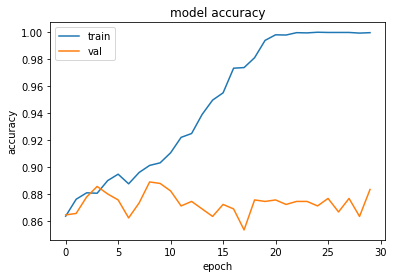

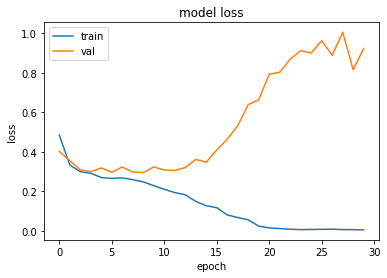

Folder num 6
Genre split [['International'], ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 16s 152ms/step - loss: 0.4796 - accuracy: 0.8569 - val_loss: 0.3559 - val_accuracy: 0.8854

Epoch 00001: val_accuracy improved from -inf to 0.88543, saving model to ./models/model_root_n/folder6\model.h5
Epoch 2/30
99/99 [==============================] - 14s 147ms/step - loss: 0.3714 - accuracy: 0.8720 - val_loss: 0.3325 - val_accuracy: 0.8854

Epoch 00002: val_accuracy did not improve from 0.88543
Epoch 3/30
99/99 [==============================] - 16s 161ms/step - loss: 0.3486 - accuracy: 0.8753 - val_loss: 0.2914 - val_accuracy: 0.8865

Epoch 00003: val_accuracy improved from 0.88543 to 0.88654, saving model to ./models/model_root_n/folder6\model.h5
Epoch 4/30
99/99 [==============================] - 14s 146ms/step - loss: 0.3365 - accuracy: 0.8783 - val_loss: 0.2946 - val_acc

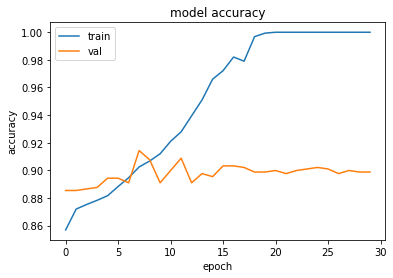

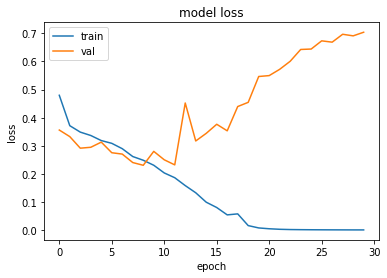

Folder num 7
Genre split [['Pop'], ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 17s 161ms/step - loss: 0.6187 - accuracy: 0.8596 - val_loss: 0.3682 - val_accuracy: 0.8865

Epoch 00001: val_accuracy improved from -inf to 0.88654, saving model to ./models/model_root_n/folder7\model.h5
Epoch 2/30
99/99 [==============================] - 15s 149ms/step - loss: 0.3861 - accuracy: 0.8732 - val_loss: 0.3502 - val_accuracy: 0.8865

Epoch 00002: val_accuracy did not improve from 0.88654
Epoch 3/30
99/99 [==============================] - 14s 147ms/step - loss: 0.3818 - accuracy: 0.8732 - val_loss: 0.3550 - val_accuracy: 0.8865

Epoch 00003: val_accuracy did not improve from 0.88654
Epoch 4/30
99/99 [==============================] - 15s 148ms/step - loss: 0.3810 - accuracy: 0.8732 - val_loss: 0.3584 - val_accuracy: 0.8865

Epoch 00004: val_accuracy did not improve fro

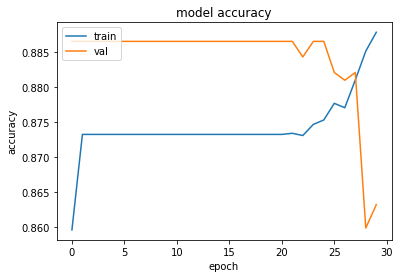

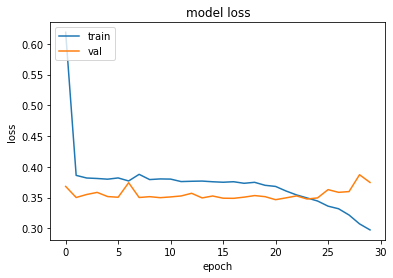

Folder num 8
Genre split [['Rock'], ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
99/99 [==============================] - 17s 154ms/step - loss: 0.5616 - accuracy: 0.8593 - val_loss: 0.3272 - val_accuracy: 0.8743

Epoch 00001: val_accuracy improved from -inf to 0.87430, saving model to ./models/model_root_n/folder8\model.h5
Epoch 2/30
99/99 [==============================] - 14s 146ms/step - loss: 0.3080 - accuracy: 0.8761 - val_loss: 0.3342 - val_accuracy: 0.8732

Epoch 00002: val_accuracy did not improve from 0.87430
Epoch 3/30
99/99 [==============================] - 15s 147ms/step - loss: 0.2958 - accuracy: 0.8801 - val_loss: 0.2933 - val_accuracy: 0.8899

Epoch 00003: val_accuracy improved from 0.87430 to 0.88988, saving model to ./models/model_root_n/folder8\model.h5
Epoch 4/30
99/99 [==============================] - 14s 146ms/step - loss: 0.2865 - accuracy: 0.8836 - val_loss: 0.2811 - val_acc

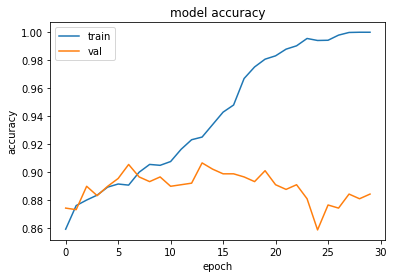

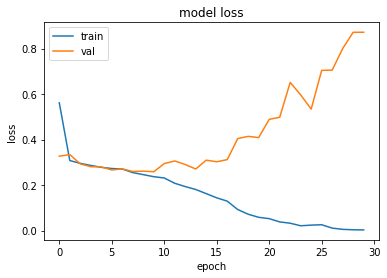

In [18]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 8

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    dict_genres_list = list(dict_genres.values())
    split = [[dict_genres_list.pop(fold_no - 1)], dict_genres_list]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)
    
    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break